<a href="https://colab.research.google.com/github/sepehrkr/Deep-Learning-Course/blob/main/HW3/Deep_HW3_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part A

##1.

##### In deformable Convolution we can use an offset for each pixel instead of using grid. so we can attention to pixels in an arbitary manner. but in vanilla convoutions we should use regular grid to attend pixels. for example if we have a kernel 3x3, in regular convolution we use 3x3 grid to update each pixel value. In deformable convolution we use 9 pixel to update each pixel as we did in vanilla convoultion but here we are not forced to use the regular 3x3 grid. The pixels could come from any location in the image. Even they could not fit in to the grid, so in this cases we should interpolate that fractional pixels.

## 2.



They can be fleable to geometric transformations becasue the our kernels have not any special shape, so we deformed object we can adjust our kernel to fit hose object as we do for regualr objects in vanilla convolution. actually becasue the selction of pixels in linear process, so any Linear geometric trasnformation can be handled by deformable convolution.

## 3.

Becasue they vanilla convolution acts on regular grid, so if an object has been deformed such as rotated so much or any other trasnformation, the convolution can not act on ther as it does on regular objects. for example if in some layer the convoltion is triying to detect edges, if some edges have been deformaed the convolution just approximate this edges with regual shape of them not the exact shape. for solving this sproblem we hould agument our dataset before training out model to force network to pick specefic senario in each trasnfomration. but the power of the netork is just limited to the variations in dataset.

## 4.

for genrating offsets, we pass the feature map through convolutiuon network. the output is a feature map with depth $2N$, where $N$ is the number of pixels in our kernel. for example if the kernel size is $3\times 3$, then $N=9$. but for each pixel we have $2N$ features becasue out grid is 2D. so the offsets need $x$ and $y$ direction for exach pixel.

#Part B

### Preparing Data with COCO API

In [ ]:
!pip install pycocotools

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip /content/annotations_trainval2017.zip

--2023-12-22 16:53:22--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.93.179, 3.5.25.163, 52.217.91.164, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.93.179|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  44.7MB/s    in 5.8s    

2023-12-22 16:53:28 (41.8 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  /content/annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import os
import random
from pycocotools.coco import COCO
import requests
import pickle
from tqdm import tqdm
from torchvision import datasets
import matplotlib.pyplot as plt

In [ ]:
annotation_train_dir = './annotations/instances_train2017.json'
annotation_val_dir = './annotations/instances_val2017.json'

coco_train = COCO(annotation_train_dir)
coco_val = COCO(annotation_val_dir)

cats = coco_train.loadCats(coco_train.getCatIds())

loading annotations into memory...
Done (t=23.79s)
creating index...
index created!
loading annotations into memory...
Done (t=1.13s)
creating index...
index created!


In [ ]:
os.makedirs('./Images/Train')
os.makedirs('./Images/Val')

In [ ]:
train_dir = './Images/Train'
val_dir = './Images/Val'

selected_cats = []
train_images = []
val_images = []
counter = 0

for i,cat_info in enumerate(cats):
  cat_name = cat_info['name']
  cat_id = cat_info['id']

  train_images_id = coco_train.getImgIds(catIds=cat_id)
  val_images_id = coco_val.getImgIds(catIds=cat_id)

  if len(val_images_id)<125 or len(train_images_id)<500:
    continue

  selected_cats.append(cat_name)
  train_images.append((random.sample(train_images_id, k=500), cat_name))
  val_images.append((random.sample(val_images_id, k=125), cat_name))
  counter += 1
  if counter == 10:
    break

cat_dict = {}
for i, name in enumerate(selected_cats):
  cat_dict[name] = i

train_image_cats = []
val_image_cats = []
for train, val in zip(train_images, val_images):

  train_images_id, cat = train
  val_images_id, _ = val

  for train_image_id in train_images_id:
    timage_info = coco_train.loadImgs(ids=train_image_id)[0]
    timage_name = timage_info['file_name']
    timage_url = timage_info['coco_url']
    tresponse = requests.get(timage_url)
    if tresponse.status_code == 200:
      with open(os.path.join(train_dir, timage_name), 'wb') as f:
        f.write(tresponse.content)
        train_image_cats.append((timage_name,cat))
    else:
      print(f"Failed to download: {timage_name}")

  for val_image_id in val_images_id:
    vimage_info = coco_val.loadImgs(ids=val_image_id)[0]
    vimage_name = vimage_info['file_name']
    vimage_url = vimage_info['coco_url']
    vresponse = requests.get(vimage_url)
    if vresponse.status_code == 200:
      with open(os.path.join(val_dir, vimage_name), 'wb') as f:
        f.write(vresponse.content)
        val_image_cats.append((vimage_name,cat))
    else:
      print(f"Failed to download: {vimage_name}")

### Creating Dataset

In [ ]:
class COCODataset(Dataset):
  def __init__(self, root, which, dataset, cat_dict, transform):
    super().__init__()
    assert which in {'Train', 'Val'}
    self.root = root
    self.path = os.path.join(root,which)
    self.dataset = dataset
    self.cat_dict = cat_dict
    self.transform = transform

  def __getitem__(self, index):
    image_name, cat = self.dataset[index]
    image = self.transform(Image.open(os.path.join(self.path, image_name)).convert('RGB'))
    cat = self.cat_dict[cat]
    return (image, cat)

  def __len__(self):
    return len(self.dataset)

In [ ]:
img_transform = transforms.Compose([
    transforms.Resize((16,16),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
trainset = COCODataset('./Images','Train',train_image_cats,cat_dict,img_transform)
valset = COCODataset('./Images','Val',val_image_cats,cat_dict,img_transform)

trainLoader = DataLoader(trainset,batch_size=8,shuffle=True)
valLoader = DataLoader(valset,batch_size=8,shuffle=False)

In [ ]:
# save trainLoader and valLoader
with open('/content/drive/MyDrive/trainLoader.pkl','wb') as f:
  pickle.dump(trainLoader,f)

with open('/content/drive/MyDrive/valLoader.pkl','wb') as f:
  pickle.dump(valLoader,f)

In [ ]:
# load trainLoader and valLoader
with open('/content/drive/MyDrive/trainLoader.pkl','rb') as f:
  trainLoader = pickle.load(f)

with open('/content/drive/MyDrive/valLoader.pkl','rb') as f:
  valLoader = pickle.load(f)

### Model

In [ ]:
class DeformableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, device):
        super().__init__()
        self.kernel_size = kernel_size
        self.N = kernel_size[0] * kernel_size[1]
        self.conv2 = nn.Conv2d(in_channels, 2*self.N*in_channels, kernel_size,stride,padding)
        self.W = nn.Parameter(torch.zeros((out_channels, in_channels, kernel_size[0], kernel_size[1])))
        self.B = nn.Parameter(torch.zeros((out_channels,)))
        self.intialize(in_channels)
        self.device = device


    def intialize(self, in_channels):
        k = torch.sqrt(torch.tensor(1/(in_channels*self.kernel_size[0]*self.kernel_size[1])))
        nn.init.uniform_(self.W,-k,k)
        nn.init.uniform_(self.B,-k,k)


    def grid_adjusting(self, points:torch.Tensor, x:torch.Tensor):
        # points has shape B x c*2N x H x W
        # x has shape B x C x H x W
        points = points.reshape(points.shape[0],points.shape[1]//(2*self.N),self.N,2,points.shape[2],points.shape[3]).permute(0,1,4,5,2,3) # * x N x 2

        pn_x, pn_y = torch.meshgrid(torch.arange(-(self.kernel_size[0]//2),self.kernel_size[0]//2+1),torch.arange(-(self.kernel_size[1]//2),self.kernel_size[1]//2+1))
        pn_x = pn_x.flatten().to(self.device)
        pn_y = pn_y.flatten().to(self.device)
        p0_x, p0_y = torch.meshgrid(torch.arange(0,x.shape[-2]),torch.arange(0,x.shape[-1]))
        p0_x = p0_x.to(device)
        p0_y = p0_y.to(device)
        px = p0_x[:,:,None]+pn_x+points[:,:,:,:,:,0]
        py = p0_y[:,:,None]+pn_y+points[:,:,:,:,:,1]

        G = torch.max(torch.tensor(0,device=self.device),1-torch.abs(p0_x[:,:]-px[:,:,:,:,:,None,None])) * torch.max(torch.tensor(0,device=self.device),1-torch.abs(p0_y[:,:]-py[:,:,:,:,:,None,None]))
        mult = (G * x[:,:,None,None,None,:,:]).sum(dim=(-2,-1))
        return (self.W.flatten(-2)[None,:,:,None,None,:] * mult[:,None,:,:,:,:]).sum(dim=(-1,-4))


    def forward(self, x):
        # x has shape B x C x H x W
        offsets = self.conv2(x)
        return self.grid_adjusting(offsets,x)


In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [DeformableConv(in_channels, out_channels, (3,3), 1, 1,device),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d((2,2),2))
    return nn.Sequential(*layers)

class DeformableNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = conv_block(3, 64) # 16
        self.conv2 = conv_block(64, 128, pool=True) # 8
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 256)) #8
        self.conv3 = nn.Conv2d(128,256,(1,1))
        self.conv4 = conv_block(256, 512, pool=True) # 4

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, 10))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + self.conv3(out)
        out = self.conv4(out)
        out = self.classifier(out)
        return out

In [ ]:
model = DeformableNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

num_epochs = 10
losses = []
accuracies = []
len_trainLoader = len(trainLoader)
for epoch in range(num_epochs):
  model.train()
  current_loss = 0.0
  accuracy = 0.0
  tqdm_bar = tqdm(trainLoader, desc=f'Training Epoch {epoch} ', total=int(len_trainLoader))
  for i,(images, targets) in enumerate(tqdm_bar):
    images = images.to(device)
    targets = targets.to(device)
    labels = model(images)
    optimizer.zero_grad()
    loss = criterion(labels,targets)
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    _, prediction = torch.max(labels,dim=1)
    accuracy += (prediction==targets).sum()/batch_size # to prevent overflow.

  current_loss /= len_trainLoader
  losses.append(current_loss)
  accuracy = accuracy*batch_size/num_images
  accuracies.append(accuracy)
  print(f"Loss: {current_loss}, Accuracy: {accuracy}")
  torch.save(model.state_dict(), '/content/drive/MyDrive/Defnet.pth')


### all below accuracies must multiplies 2 and losses must divied by 2, becasue i set batch size to 8 but i devided accuraccies to 16

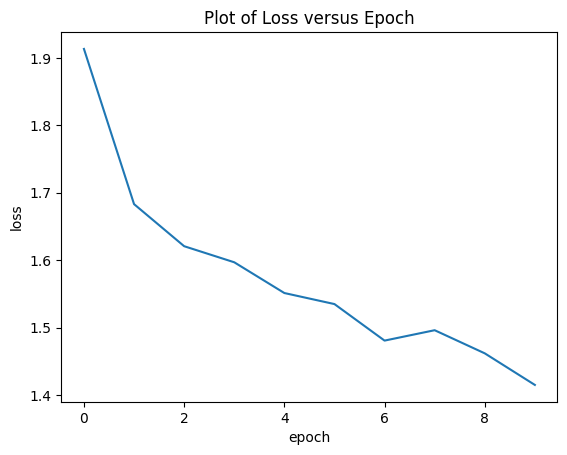

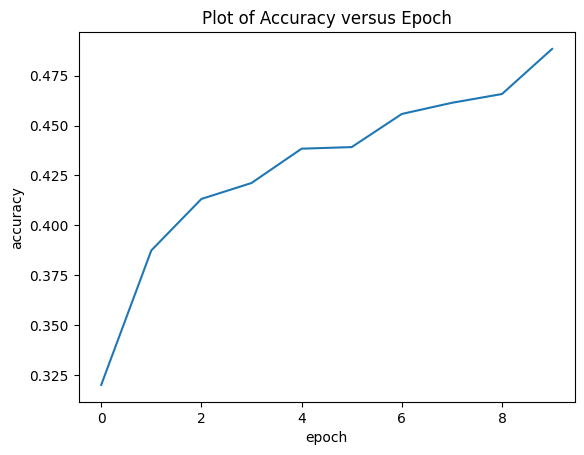

In [ ]:
plt.figure()
plt.plot(range(num_epochs),losses)
plt.title("Plot of Loss versus Epoch")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

accuracies = [accuracy.cpu() for accuracy in accuracies]
plt.figure()
plt.plot(range(num_epochs),accuracies)
plt.title("Plot of Accuracy versus Epoch")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()


In [ ]:
model.eval()
accuracy = 0.0
with torch.no_grad():
  for i,(images, targets) in enumerate(valLoader):
    images = images.to(device)
    targets = targets.to(device)
    labels = model(images)
    _, prediction = torch.max(labels,dim=1)
    accuracy += (prediction==targets).sum()

accuracy /= (len(valLoader)*8)
print(f"Accuracy of test set: {accuracy}")


Accuracy of test set: 0.8813291192054749


In [ ]:
def conv_block_vanilla(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, (3,3), 1, 1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d((2,2),2))
    return nn.Sequential(*layers)

class RegularNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = conv_block_vanilla(3, 64) # 16
        self.conv2 = conv_block_vanilla(64, 128, pool=True) # 8
        self.res1 = nn.Sequential(conv_block_vanilla(128, 128), conv_block_vanilla(128, 256)) #8
        self.conv3 = nn.Conv2d(128,256,(1,1))
        self.conv4 = conv_block_vanilla(256, 512, pool=True) # 4

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, 10))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + self.conv3(out)
        out = self.conv4(out)
        out = self.classifier(out)
        return out

In [ ]:
batch_size = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_images = len(trainset)

model_regular = RegularNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_regular.parameters(),lr=0.001)

num_epochs = 10
losses = []
accuracies = []
len_trainLoader = len(trainLoader)
for epoch in range(num_epochs):
  model_regular.train()
  current_loss = 0.0
  accuracy = 0.0
  tqdm_bar = tqdm(trainLoader, desc=f'Training Epoch {epoch} ', total=int(len_trainLoader))
  for i,(images, targets) in enumerate(tqdm_bar):
    images = images.to(device)
    targets = targets.to(device)
    labels = model_regular(images)
    optimizer.zero_grad()
    loss = criterion(labels,targets)
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    _, prediction = torch.max(labels,dim=1)
    accuracy += (prediction==targets).sum()/batch_size # to prevent overflow.

  current_loss /= len_trainLoader
  losses.append(current_loss)
  accuracy = accuracy*batch_size/num_images
  accuracies.append(accuracy)
  print(f"Loss: {current_loss}, Accuracy: {accuracy}")
  torch.save(model_regular.state_dict(), '/content/drive/MyDrive/RegualNet.pth')


Training Epoch 0 : 100%|██████████| 625/625 [00:08<00:00, 73.53it/s]


Loss: 1.9554063983917236, Accuracy: 0.31700000166893005


Training Epoch 1 : 100%|██████████| 625/625 [00:07<00:00, 79.90it/s]


Loss: 1.6756327179908752, Accuracy: 0.4107999801635742


Training Epoch 2 : 100%|██████████| 625/625 [00:07<00:00, 80.93it/s]


Loss: 1.4767771349906922, Accuracy: 0.4909999966621399


Training Epoch 3 : 100%|██████████| 625/625 [00:07<00:00, 87.51it/s] 


Loss: 1.2824749399662019, Accuracy: 0.5503999590873718


Training Epoch 4 : 100%|██████████| 625/625 [00:11<00:00, 56.69it/s]


Loss: 1.1341118632793425, Accuracy: 0.5977999567985535


Training Epoch 5 : 100%|██████████| 625/625 [00:07<00:00, 83.11it/s] 


Loss: 0.9125900604009628, Accuracy: 0.6829999685287476


Training Epoch 6 : 100%|██████████| 625/625 [00:10<00:00, 58.14it/s]


Loss: 0.7588072599411011, Accuracy: 0.7396000027656555


Training Epoch 7 : 100%|██████████| 625/625 [00:10<00:00, 61.72it/s]


Loss: 0.606475509351492, Accuracy: 0.7978000044822693


Training Epoch 8 : 100%|██████████| 625/625 [00:08<00:00, 70.81it/s]


Loss: 0.40015468997061254, Accuracy: 0.8661999702453613


Training Epoch 9 : 100%|██████████| 625/625 [00:09<00:00, 67.01it/s]

Loss: 0.2572735122770071, Accuracy: 0.9228000044822693


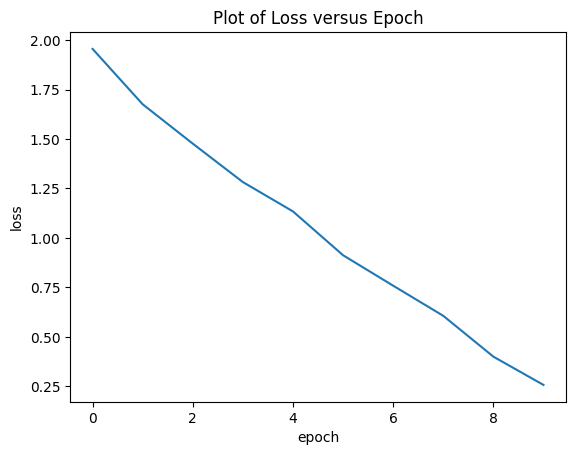

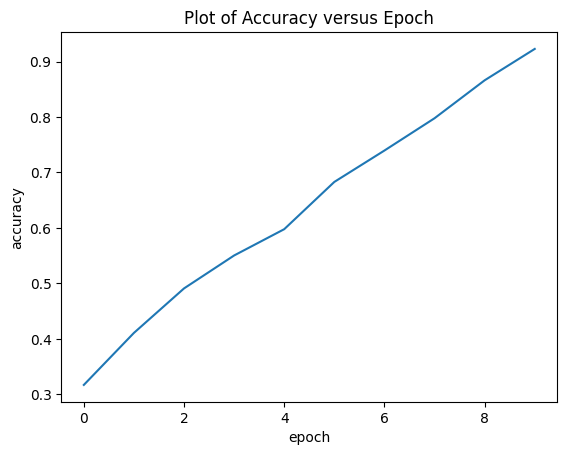

In [ ]:
plt.figure()
plt.plot(range(num_epochs),losses)
plt.title("Plot of Loss versus Epoch")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

accuracies = [accuracy.cpu() for accuracy in accuracies]
plt.figure()
plt.plot(range(num_epochs),accuracies)
plt.title("Plot of Accuracy versus Epoch")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()


In [ ]:
model_regular.eval()
accuracy = 0.0
with torch.no_grad():
  for i,(images, targets) in enumerate(valLoader):
    images = images.to(device)
    targets = targets.to(device)
    labels = model_regular(images)
    _, prediction = torch.max(labels,dim=1)
    accuracy += (prediction==targets).sum()

accuracy /= (len(valLoader)*8)
print(f"Accuracy of test set: {accuracy}")

Accuracy of test set: 0.656050980091095


# Part C

Def Train Accuracy: 92%

Def Val Accuracy: 88%

Vanilla Train Accuracy: 92%

Vanilla Val Accuracy: 66%

Def Train Loss : 0.7

Def Val Loss : 0.74

Reg Train Loss : 0.25

Reg Val Loss : 0.88

Time for training Deformable : 44 min

Time for training Vanilla : 2 min

Time for validating Deformable: 11 sec

Time for validating Vanilla: 2 sec